# Prerequisites

In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

from sklearn.model_selection  import train_test_split

import numpy as np
import pandas as pd
from datetime import datetime, date
import time

# DeepSpeed ZeRO-3
# import deepspeed
# from deepspeed.accelerator import get_accelerator

In [9]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [10]:
(free_memory, global_memory) = torch.cuda.mem_get_info()
print(f"Free(GB): {free_memory/1024/1024/1024}, Global(GB): {global_memory/1024/1024/1024}, Free(%): {free_memory/global_memory}")

Free(GB): 22.8790283203125, Global(GB): 23.64971923828125, Free(%): 0.9674122593082944


# Load Excel File

In [11]:
import pandas as pd
master_df = pd.read_excel('./DATASETS/Training_Dataset.xlsx')
master_df.head()

,Type,Identity,Text,A2-Unambiguous,A4-Tolerances,A5-Sources specified,E1
0,ast_adc,HLRS_1747,Massive Data Broadcast shall immediately send ...,1,na,1,1
1,ast_adc,HLRS_6673,Massive Data Broadcast shall place a copied Re...,1,na,1,1
2,ast_adc,HLRS_2470,Massive Data Broadcast shall place a copied Ma...,1,na,1,1
3,ast_adc,HLRS_2467,Massive Data Broadcast shall send the current ...,1,na,na,1
4,ast_adc,HLRS_2468,Massive Data Broadcast shall send the current ...,1,na,na,1


In [12]:
model_df = master_df[['E1','Text']].copy()
model_df.head()

,E1,Text
0,1,Massive Data Broadcast shall immediately send ...
1,1,Massive Data Broadcast shall place a copied Re...
2,1,Massive Data Broadcast shall place a copied Ma...
3,1,Massive Data Broadcast shall send the current ...
4,1,Massive Data Broadcast shall send the current ...


In [13]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3124 entries, 0 to 3123
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E1      3124 non-null   int64 
 1   Text    3124 non-null   object
dtypes: int64(1), object(1)
memory usage: 48.9+ KB


In [14]:
model_df_label1 = model_df.query('E1 == 1')
len(model_df_label1)

2127

In [15]:
model_df_label0 = model_df.query('E1 == 0')
len(model_df_label0)

997

In [16]:
model_df = pd.concat([model_df_label1[500:1100],model_df_label0])

# Data process and tokenizer

In [17]:
from sklearn.model_selection  import train_test_split
train_df, test_df = train_test_split(model_df, test_size=0.4, shuffle=True)
val_df, test_df = train_test_split(test_df, test_size=0.5, shuffle=True)

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
val_iter = iter(list(val_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [18]:
len(train_df)

958

In [19]:
tokenizer = torch.hub.load(
    "huggingface/pytorch-transformers",
    "tokenizer",
    "openai-community/gpt2",
)

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main


In [20]:
tokenizer

GPT2TokenizerFast(name_or_path='openai-community/gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

# Dataset iterator

In [21]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
val_iter = iter(list(val_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [22]:
next(train_iter)

(1,
 'The Network Function shall support to configure up to and including 1 external connected Bluetooth device.')

In [23]:
from torch.utils.data import DataLoader

# function passed to the DataLoader to process a batch of data as indicated
tokenizer.pad_token = tokenizer.eos_token

def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    encoded_x = tokenizer(x, padding=True, truncation=True)
    encoded_x.input_ids = torch.tensor(encoded_x.input_ids).to(device)
    encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask).to(device)  
        
    return encoded_x, torch.tensor(y, dtype=torch.long).to(device)

In [24]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
first = next(train_iter)
second = next(train_iter)

print(first)
print(second)

collate_batch([first, second])

(1, 'The Network Function shall support to configure up to and including 1 external connected Bluetooth device.')
(0, 'At initialization, if the server can connect to the service, it shall log a successful connection message using the LTS.')


({'input_ids': [[464, 7311, 15553, 2236, 1104, 284, 17425, 510, 284, 290, 1390, 352, 7097, 5884, 19263, 3335, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256], [2953, 37588, 11, 611, 262, 4382, 460, 2018, 284, 262, 2139, 11, 340, 2236, 2604, 257, 4388, 4637, 3275, 1262, 262, 406, 4694, 13]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]},
 tensor([1, 0], device='cuda:0'))

# Define the model

In [53]:
def create_model():
    model = torch.hub.load(
        "huggingface/pytorch-transformers",
        "modelForSequenceClassification",
        "openai-community/gpt2"
    )
    
    for i, parameter in enumerate(model.parameters()):
        parameter.requires_grad = False
    
    model.score = nn.Sequential(
        nn.Linear(in_features=768, out_features=2560),
        nn.Dropout(),
        nn.Linear(in_features=2560, out_features=2)
    )
    model.config.pad_token_id = tokenizer.pad_token_id
    
    # Initializing the weights with the Kaiming initialization method 
    torch.nn.init.kaiming_uniform_(model.score[0].weight, 
                                   a=0, mode="fan_in", 
                                   nonlinearity="relu") 
    
    torch.nn.init.kaiming_uniform_(model.score[2].weight, 
                                   a=0, mode="fan_in", 
                                   nonlinearity="relu") 
    
    return model

In [54]:
model = create_model()

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
model

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Sequential(
    (0): Linear(in_features=768, out_features=2560, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=2560, out_featur

## Ensemble models

In [139]:
class GPT2Ensemble(nn.Module):
    def __init__(self, model1, model2):
        super(GPT2Ensemble, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.voting = nn.Linear(4, 2) # input will be the logits of each model, the output will be the voting-based ensemble prediction
    
    def forward(self, input_ids, attention_mask):
        outputs1 = model1(input_ids=input_ids, attention_mask=attention_mask)
        outputs2 = model2(input_ids=input_ids, attention_mask=attention_mask)
        estimators_outputs = torch.hstack((outputs1.logits, outputs2.logits))
        prediction = self.voting(estimators_outputs)
        return prediction
        

In [140]:
model1 = create_model()
model2 = create_model()

model = GPT2Ensemble(model1, model2)
model

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2Ensemble(
  (model1): GPT2ForSequenceClassification(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (score): Sequential(
      (0): Linear(in_features=768, out_features=2560, bias=True)
     

# Train and eval functions

In [156]:
from datetime import datetime, date
import time

def train(model, dataloader, epoch):
    
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()
    total_loss = 0


    for idx, (data, label) in enumerate(dataloader):         
        optimizer.zero_grad()
        
        outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
        predicted_label = outputs
        loss = criterion(predicted_label, label)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        total_loss += loss.item()
        
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f} | {}".format(
                    epoch, idx, len(dataloader), total_acc / total_count, datetime.now().isoformat()
                )
            )
            start_time = time.time()
        
     
        
    return total_acc / total_count, total_loss / total_count
        

def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):      
            outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
            predicted_label = outputs
            loss = criterion(predicted_label, label)
            
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count, loss.item() / total_count

# Split the dataset and run the model

In [157]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

BATCH_SIZE = 64  # batch size for training

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
val_iter = iter(list(val_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

train_dataset = to_map_style_dataset(train_iter)
val_dataset = to_map_style_dataset(val_iter)
test_dataset = to_map_style_dataset(test_iter)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [163]:
today = date.today().isoformat()
checkpoint_path = "./models/gpt2"
model_name = "gpt2"

# Hyperparameters
EPOCHS = 20  # epoch
LR = 0.1 # learning rate
    
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    
def train_with_hist(model, checkpoint_path):
    model = model.to(device)
    
    total_accu = None

    loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = [], [], [], []
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        accu_train, loss_train = train(model, train_dataloader, epoch)
        accu_val, loss_val = evaluate(model, valid_dataloader)
        if total_accu is not None and total_accu > accu_val:
            scheduler.step()
            print("Learning rate took a step by the scheduler {:8.3f} > {:8.3f}".format(total_accu, accu_val))
        else:
            total_accu = accu_val
        print("-" * 59)
        print(
            "| end of epoch {:3d} | time: {:5.2f}s | "
            "valid accuracy {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, accu_val
            )
        )
        print("-" * 59)

        loss_hist_train.append(loss_train)
        loss_hist_valid.append(loss_val)
        accuracy_hist_train.append(accu_train)
        accuracy_hist_valid.append(accu_val)
        
    torch.save(model, f'{checkpoint_path}/{today}_{model_name}.pt')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [164]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [165]:
hist = train_with_hist(model, checkpoint_path)

| epoch   1 |     5/   15 batches | accuracy    0.531 | 2024-05-31T22:12:25.835534
| epoch   1 |    10/   15 batches | accuracy    0.615 | 2024-05-31T22:12:26.184348
-----------------------------------------------------------
| end of epoch   1 | time:  1.83s | valid accuracy    0.599 
-----------------------------------------------------------
| epoch   2 |     5/   15 batches | accuracy    0.526 | 2024-05-31T22:12:27.597008
| epoch   2 |    10/   15 batches | accuracy    0.581 | 2024-05-31T22:12:27.980788
Learning rate took a step by the scheduler    0.599 >    0.580
-----------------------------------------------------------
| end of epoch   2 | time:  1.78s | valid accuracy    0.580 
-----------------------------------------------------------
| epoch   3 |     5/   15 batches | accuracy    0.615 | 2024-05-31T22:12:29.407744
| epoch   3 |    10/   15 batches | accuracy    0.665 | 2024-05-31T22:12:29.771968
-----------------------------------------------------------
| end of epoch   

In [166]:
import numpy as np
import matplotlib.pyplot as plt
def plot_learning_curves(hist):
    x_arr = np.arange(len(hist[0])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

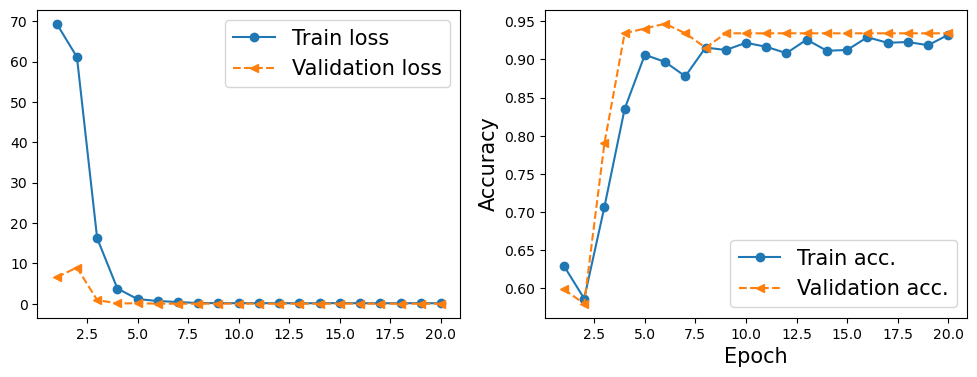

In [167]:
plot_learning_curves(hist)

### Evaluate the model with test dataset

Checking the results of the test dataset…



In [168]:
print("Checking the results of test dataset.")
accu_test, _ = evaluate(model, test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.931


In [171]:
# create confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_test = np.asarray([])
    y_predict = np.asarray([])

    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):
            outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
            predicted_label = outputs
                  
            y_test = np.concatenate((y_test, np.asarray(label.to(device='cpu', dtype=torch.long))), axis=None)
            y_predict = np.concatenate((y_predict, np.asarray((predicted_label.argmax(1).to(device='cpu', dtype=torch.long)))), axis=None)

    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt = "d")
    print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       198
         1.0       0.87      0.96      0.91       122

    accuracy                           0.93       320
   macro avg       0.92      0.94      0.93       320
weighted avg       0.93      0.93      0.93       320



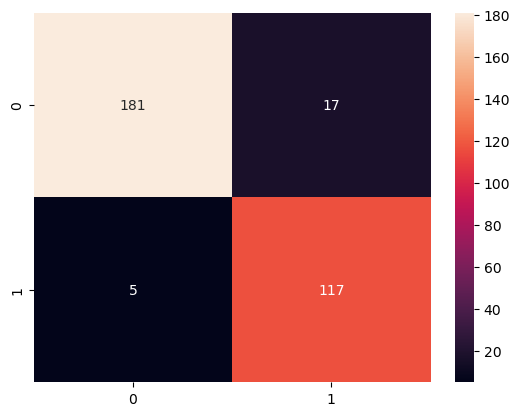

In [172]:
plot_confusion_matrix(model, test_dataloader)

In [175]:
def predict(text):
    with torch.no_grad():
        encoded_text = tokenizer(text)
        encoded_text.input_ids = torch.tensor(encoded_text.input_ids).to(device).unsqueeze(0)
        encoded_text.attention_mask = torch.tensor(encoded_text.attention_mask).to(device).unsqueeze(0)

        outputs = model(input_ids=encoded_text.input_ids, attention_mask=encoded_text.attention_mask)
        predicted_label = outputs
        return predicted_label.argmax(1).item()

In [176]:
ex_text_str = 'The ePump Software shall define Fault ID 1 as follows:'

print("This is a %s" % predict(ex_text_str))

This is a 1


In [177]:
pred_text = "The IO Service shall select the XLR-PW DEV_INFO_DATA file if HPP_XLR_WIRING is grounded (logical 1) and bits AC_TYPE_BIT1 - AC_TYPE_BIT6 do not indicate a CFM engine configuration. NOTE: HPP_XLR_WIRING and bits AC_TYPE_BIT[1-6] are discrete inputs which are received on constant pins between hardware configurations. See 282100-ICD-x for more details."
predict(pred_text)

1

In [178]:
pred_text = "I shall like waffles"
predict(pred_text)

0

In [179]:
pred_text = "Bumblebe is red"
predict(pred_text)

0

In [180]:
pred_text = "Bumblebee is red"
predict(pred_text)

0

## Eval optimized model with test dataset

In [43]:
model = torch.load("./models/gpt2/2024-04-09_gpt2_train_search_75674ade_1_batch_size_model.pt",
                  # map_location=device
                  )

In [182]:
model.model1.device

device(type='cuda', index=0)

In [183]:
test_df = pd.read_excel('./DATASETS/Testing_Dataset.xlsx')
test_df = test_df[['E1','Text']]
#Convert E1 column values to integers
test_df['E1'] = test_df['E1'].astype(int)
test_df.head()

,E1,Text
0,0,The BITE Service shall record all Shop Data.
1,0,"If the CFDIU data is not available, the System..."
2,0,The Connectivity Function shall monitor for an...
3,0,CF service shall send a data payload as UDP to...
4,0,The ESDM shall halt file transfers to the SD c...


In [184]:
tokenizer

GPT2TokenizerFast(name_or_path='openai-community/gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [190]:
from torch.utils.data import DataLoader

def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    encoded_x = tokenizer(x, padding=True, truncation=True, return_tensors='pt')
    encoded_x.input_ids = torch.tensor(encoded_x.input_ids).to(device)
    encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask).to(device)
    
    return encoded_x, torch.tensor(y, dtype=torch.long).to(device)

In [191]:
from torchtext.data.functional import to_map_style_dataset

test_iter = iter(list(test_df.itertuples(index=False, name=None)))
test_dataset = to_map_style_dataset(test_iter)
    
test_dataloader = DataLoader(test_dataset,
                             batch_size=64,
                             shuffle=False,
                             collate_fn=collate_batch)

In [199]:
# create confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_test = np.asarray([])
    y_predict = np.asarray([])

    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):
            outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
            predicted_label = outputs
                  
            y_test = np.concatenate((y_test, np.asarray(label.to(device='cpu', dtype=torch.long))), axis=None)
            y_predict = np.concatenate((y_predict, np.asarray((predicted_label.argmax(1).to(device='cpu', dtype=torch.long)))), axis=None)

    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt = "d")
    print(classification_report(y_test, y_predict))

/tmp/ipykernel_49968/67003502.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_x.input_ids = torch.tensor(encoded_x.input_ids).to(device)
/tmp/ipykernel_49968/67003502.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask).to(device)


              precision    recall  f1-score   support

         0.0       0.26      0.12      0.17       255
         1.0       0.43      0.65      0.51       255

    accuracy                           0.39       510
   macro avg       0.34      0.39      0.34       510
weighted avg       0.34      0.39      0.34       510



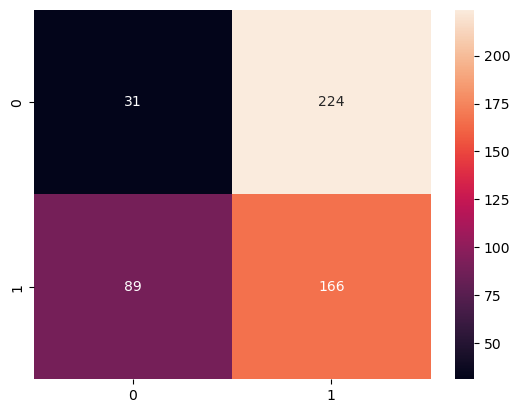

In [200]:
plot_confusion_matrix(model, test_dataloader)

### ROC Curves

In [196]:
from sklearn.metrics import roc_curve, auc

In [197]:
# Calc prediction to evaluate against ground truth
model.eval()
y_test = np.asarray([])
y_predict = np.asarray([])

with torch.no_grad():
    for idx, (data, label) in enumerate(test_dataloader):
        outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
        predicted_label = outputs

        y_test = np.concatenate((y_test, np.asarray(label.to(device='cpu', dtype=torch.long))), axis=None)
        y_predict = np.concatenate((y_predict, np.asarray((predicted_label.argmax(1).to(device='cpu', dtype=torch.long)))), axis=None)

/tmp/ipykernel_49968/67003502.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_x.input_ids = torch.tensor(encoded_x.input_ids).to(device)
/tmp/ipykernel_49968/67003502.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask).to(device)


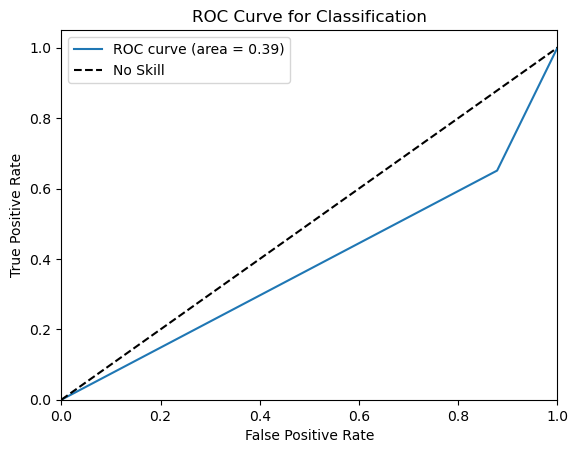

In [198]:
fpr, tpr, thresholds = roc_curve(y_test, y_predict) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classification')
plt.legend()
plt.show()

# Ensemble PyTorch

In [ ]:
num_models = 10
